In [170]:
## import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [171]:
# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [172]:
## allow all columns in view
pd.set_option('display.width', 1200)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [173]:
## loading dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
gender_data = pd.read_csv('gender_submission.csv')

In [174]:
## view train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [175]:
## insert the 'survived' column in the test dataset
test_data.insert(1, 'Survived', gender_data['Survived'])
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [176]:
## concatenate the dataset to support 80% training data
dataset = pd.concat([train_data, test_data], ignore_index=True, axis=0)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [177]:
## getting info about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [178]:
## checking for missing values
dataset.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [179]:
## visualising missing data
def plot_missing_data(dataset,tittle):
    fig,ax = plt.subplots(figsize=(5,5))
    sns.heatmap(dataset.isnull(),cbar = False)

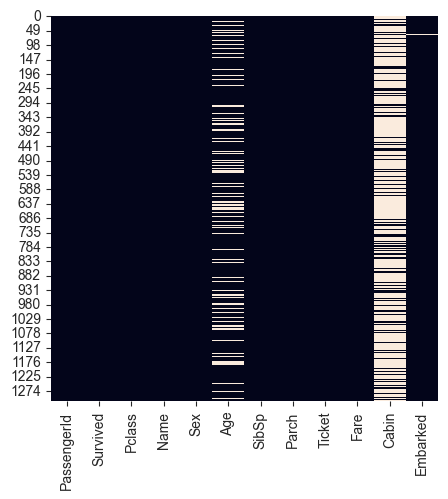

In [180]:
plot_missing_data(dataset, "working Dataset")

In [181]:
## replacing missing values with median(mid-point value) for the selected columns for better analysis
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())

In [182]:
## replacing missing values
dataset['Cabin'] = dataset['Cabin'].fillna(value='C class', limit=1014)
dataset['Embarked'] = dataset['Embarked'].fillna(value='S', limit=2)

In [183]:
## confirming the isnull values after replacement
dataset.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [184]:
## Cleaning Dataset
## tokenize names and ticket variable

def preprocess(df):
    df = df.copy()
    
    def tokenize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket(x):
        return x.split(" ")[-1]
    
    df["Name"] = dataset["Name"].apply(tokenize_name)
    df["Ticket"] = dataset["Ticket"].apply(ticket)
    return df

dataset = preprocess(dataset)

In [185]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.377387,2.294882,29.503186,0.498854,0.385027,33.295479
std,378.020061,0.484918,0.837836,12.905241,1.041658,0.865560,51.738879
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [186]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [187]:
## Grouping Features
cat_var = ["Sex", "Pclass", "Embarked", "SibSp", "Parch"] #categorical variables
target = ['Survived'] # target variable
con_var = ['Age', 'Fare'] ## continuous  variable

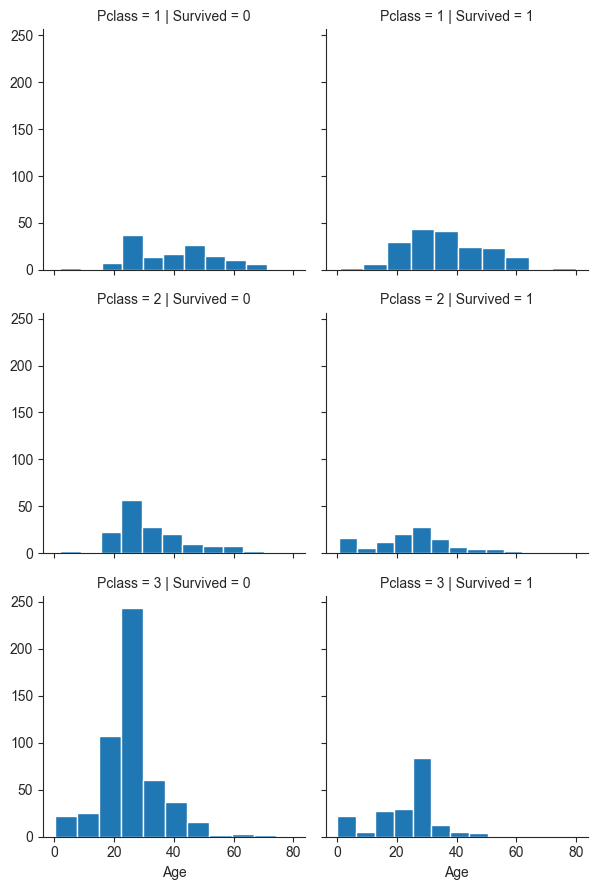

In [188]:
## initialize Facegrid to Pclass Survived by Age
fg = sns.FacetGrid(dataset, col='Survived', row='Pclass')

fg.map(plt.hist, 'Age')
fg.add_legend()
plt.show()

<Axes: xlabel='Age', ylabel='Fare'>

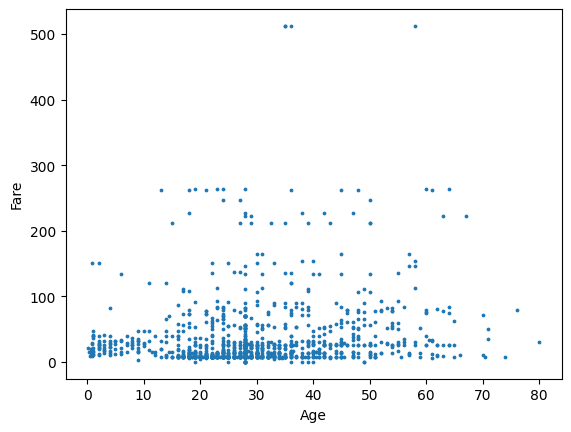

In [ ]:
## visualising continuous variables of Age and Fare
dataset.plot(kind='scatter', x='Age', y='Fare', s=3)

In [ ]:
gender_group = dataset.groupby(['Sex', 'Survived']).size()
gender_group

Sex     Survived
female  0            81
        1           385
male    0           734
        1           109
dtype: int64

In [ ]:
def barchart_plot(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    died = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_died = pd.DataFrame([survived,died])
    df_survived_died.index = ['Survived','Died']
    ax = df_survived_died.plot(kind='bar',stacked=stacked, figsize=(5,5))

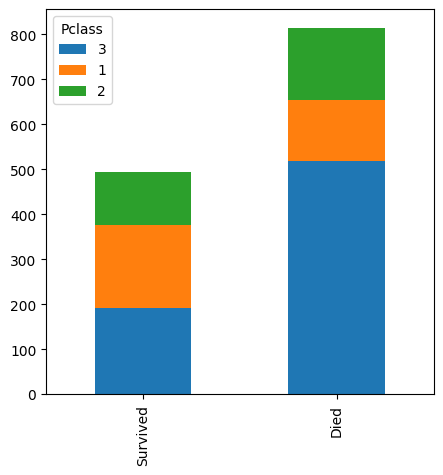

In [ ]:
barchart_plot(dataset, "Pclass")

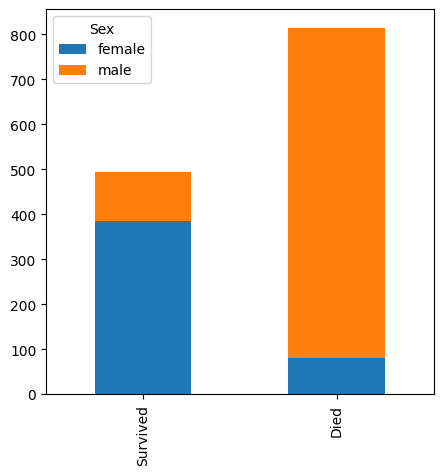

In [ ]:
## visualising Gender group 
barchart_plot(dataset, 'Sex')

In [ ]:
## exploratory data analysis
## correlation matrix

corr_mat = dataset.corr(numeric_only=True)
corr_mat

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.020370,-0.038354,0.025799,-0.055224,0.008942,0.031416
Survived,-0.020370,1.000000,-0.264710,-0.043286,0.002370,0.108919,0.233568
Pclass,-0.038354,-0.264710,1.000000,-0.377908,0.060832,0.018322,-0.558477
Age,0.025799,-0.043286,-0.377908,1.000000,-0.189972,-0.125851,0.178860
SibSp,-0.055224,0.002370,0.060832,-0.189972,1.000000,0.373587,0.160224
Parch,0.008942,0.108919,0.018322,-0.125851,0.373587,1.000000,0.221522
Fare,0.031416,0.233568,-0.558477,0.178860,0.160224,0.221522,1.000000


<Axes: >

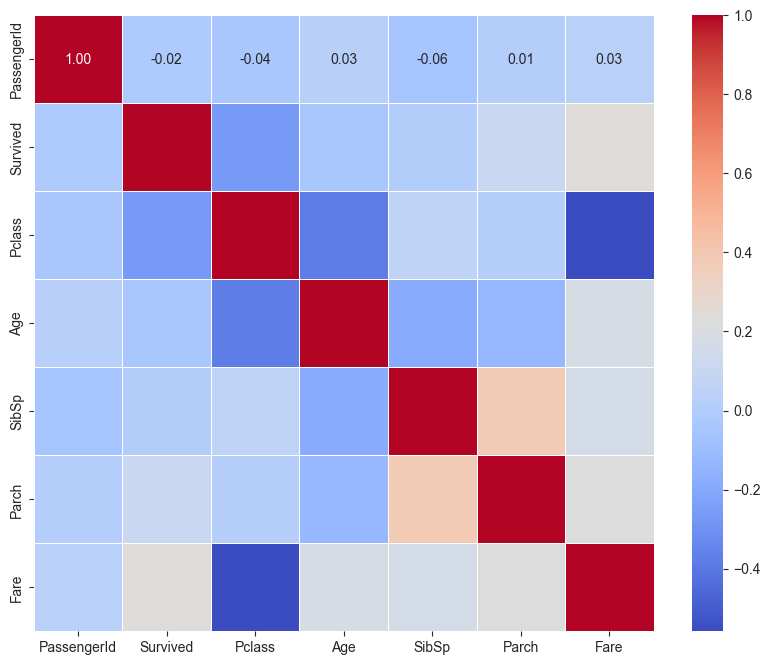

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

In [ ]:
## categorising family members and group travellers
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
dataset['Alone'] = dataset['FamilySize'].map({1:1})
dataset['Alone'].fillna(0.0, inplace=True)


In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,21171,7.2500,C class,S,2,0.0
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,17599,71.2833,C85,C,2,0.0
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,3101282,7.9250,C class,S,1,1.0
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,2,0.0
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,C class,S,1,1.0


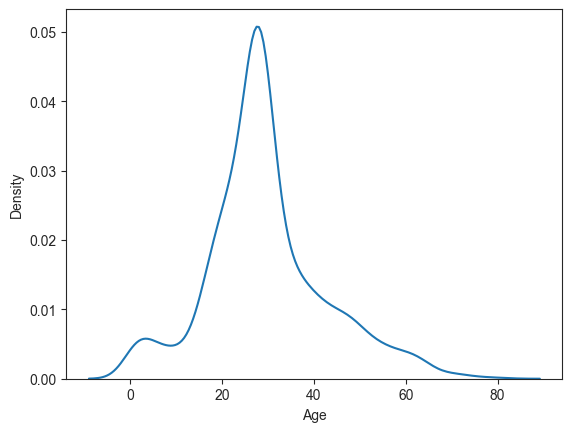

In [ ]:
## plotting for Age from the dataset
sns.distplot(dataset['Age'], hist=False)
plt.show()

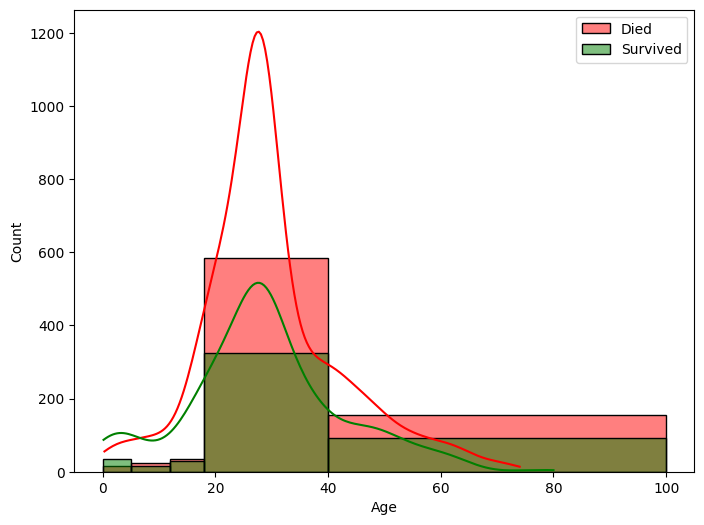

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(dataset.Age[dataset.Survived == 0], bins = [0, 5, 12, 18, 40, 100], kde=True,color="r", label="Died")
sns.histplot(dataset.Age[dataset.Survived == 1], bins = [0, 5, 12, 18, 40, 100], kde=True,color="g", label="Survived")
plt.legend()

In [ ]:
## Survived count showing dead(0) and survivors(1)
dataset['Survived'].value_counts()

Survived
0    815
1    494
Name: count, dtype: int64

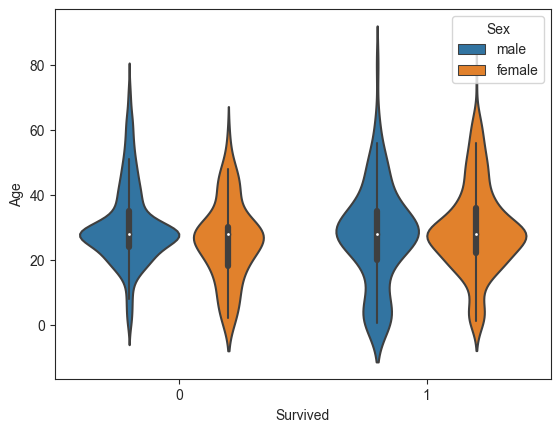

In [ ]:
## violinplot for Gender Survived
sns.violinplot(x='Survived', y='Age', hue='Sex', data=dataset)
plt.show()

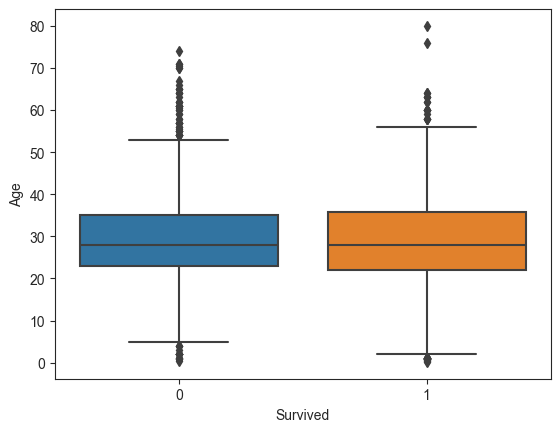

In [ ]:
## box plot of Survivors by Age
plt.Figure(figsize=(8,10))
sns.boxplot(x='Survived', y='Age', data=dataset)
plt.show()

In [ ]:
def plot_swarm_survivors(dataset, feature1, feature2, title, marker_size=5):
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.grid(True)
    plt.xticks(list(range(0, 10, 2)))
    
    sns.swarmplot(y=feature1, x=feature2, hue='Survived', data=dataset, s=marker_size)
    ax.set_title(title)

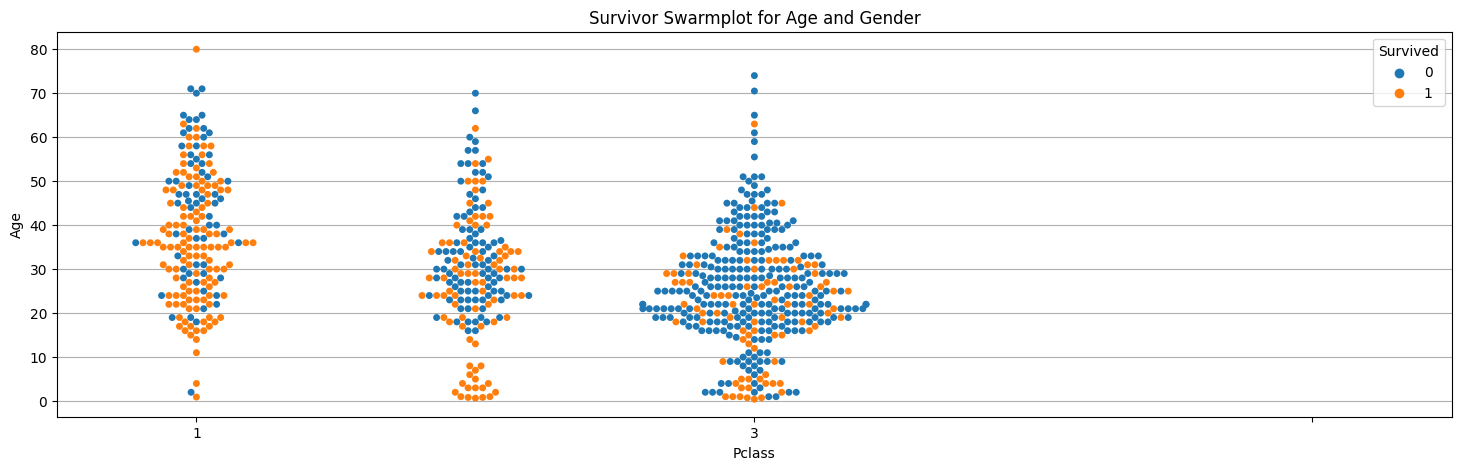

In [ ]:
## analyse age and pclass
plot_swarm_survivors(train_data, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,21171,7.2500,C class,S,2,0.0
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,17599,71.2833,C85,C,2,0.0
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,3101282,7.9250,C class,S,1,1.0
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,2,0.0
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,C class,S,1,1.0


In [ ]:
## split our data into features and target variable

x0 = dataset[['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']]
y0 = dataset['Survived']

In [ ]:
## split data into training and testing data
## 80% for training, 20% for testing

x0_train, x0_test, y0_train, y0_test = train_test_split(x0, y0, test_size=0.20, random_state=32)

In [ ]:
## standard scaler
scaler = StandardScaler()
x0_train = scaler.fit_transform(x0_train)
x0_test = scaler.transform(x0_test)

In [ ]:
log_reg0 = LogisticRegression()
log_reg0.fit(x0_train, y0_train)

LogisticRegression()

In [ ]:
## make prediction
y_pred_log0 = log_reg0.predict(x0_test)

In [ ]:
# make this in a dataframe
dis = pd.DataFrame({'Actual_Survived': y0_test, 'Predicted_Survived':y_pred_log0})
dis.insert(0, 'Name', dataset['Name'])
dis.head(10)

,Name,Actual_Survived,Predicted_Survived
872,Carlsson Mr Frans Olof,0,0
270,Cairns Mr Alexander,0,1
987,Cavendish Mrs Tyrell William Julia Florence Si...,1,0
1214,Rowe Mr Alfred G,0,0
113,Jussila Miss Katriina,0,0
218,Bazzani Miss Albina,1,1
749,Connaghton Mr Michael,0,0
620,Yasbeck Mr Antoni,0,0
607,Daniel Mr Robert Williams,1,1
283,Dorking Mr Edward Arthur,1,0


In [ ]:
## model evaluation
print('Accuracy:', metrics.accuracy_score(y0_test, y_pred_log0))

Accuracy: 0.6793893129770993


In [ ]:
## confusion matrix
conf_mat = confusion_matrix(y0_test, y_pred_log0)
conf_mat

array([[137,  19],
       [ 65,  41]])

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,21171,7.2500,C class,S,2,0.0
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,17599,71.2833,C85,C,2,0.0
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,3101282,7.9250,C class,S,1,1.0
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,2,0.0
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,C class,S,1,1.0


In [ ]:
data_object = (dataset.iloc[:, 3:5])
data_object.head()

,Name,Sex
0,Braund Mr Owen Harris,male
1,Cumings Mrs John Bradley Florence Briggs Thayer,female
2,Heikkinen Miss Laina,female
3,Futrelle Mrs Jacques Heath Lily May Peel,female
4,Allen Mr William Henry,male


In [ ]:
mina = dataset.select_dtypes(include=object)
mina.head()

,Name,Sex,Ticket,Cabin,Embarked
0,Braund Mr Owen Harris,male,21171,C class,S
1,Cumings Mrs John Bradley Florence Briggs Thayer,female,17599,C85,C
2,Heikkinen Miss Laina,female,3101282,C class,S
3,Futrelle Mrs Jacques Heath Lily May Peel,female,113803,C123,S
4,Allen Mr William Henry,male,373450,C class,S


In [ ]:
## 2nd regression 
## using Encoding labels method

## Encode Labels to transform unusable data types

LE = LabelEncoder()
data_LE = dataset
for x in data_LE.select_dtypes(["object_"]).columns:
    data_LE[x] = LE.fit_transform(data_LE[x]).astype("str")


In [ ]:
data_LE = data_LE[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize','Alone', 'Survived']]
data_LE.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Survived
0,1,3,155,1,22.0,1,0,209,7.2500,61,2,2,0.0,0
1,2,1,286,0,38.0,1,0,166,71.2833,107,0,2,0.0,1
2,3,3,523,0,26.0,0,0,466,7.9250,61,2,1,1.0,1
3,4,1,422,0,35.0,1,0,67,53.1000,71,2,2,0.0,1
4,5,3,22,1,35.0,0,0,832,8.0500,61,2,1,1.0,0


In [ ]:
## select the dependent and independent variables
x1 = data_LE.iloc[:, 0:13]
y1 = data_LE.iloc[:, 13]

In [ ]:
## splitting our data
## 80% for training, 20% for testing

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.20, random_state=40)

In [ ]:
## standard scaler
scaler = StandardScaler()
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)

In [ ]:
log_reg1 = LogisticRegression()
log_reg1.fit(x1_train, y1_train)

LogisticRegression()

In [ ]:
## make prediction
y_pred_log1 = log_reg1.predict(x1_test)

In [ ]:
# make this in a dataframe
dis_LE= pd.DataFrame({'Actual_Survived': y1_test, 'Predicted_Survived':y_pred_log1})
dis_LE.head()

,Actual_Survived,Predicted_Survived
966,0,0
283,1,0
512,1,0
547,1,0
345,1,1


In [ ]:
dis_LE.insert(0, 'Name', data_object['Name'])
dis_LE.head(10)

,Name,Actual_Survived,Predicted_Survived
966,Keeping Mr Edwin,0,0
283,Dorking Mr Edward Arthur,1,0
512,McGough Mr James Robert,1,0
547,Padro y Manent Mr Julian,1,0
345,Brown Miss Amelia Mildred,1,1
920,Samaan Mr Elias,0,0
275,Andrews Miss Kornelia Theodosia,1,1
1156,Lyntakoff Mr Stanko,0,0
849,Goldenberg Mrs Samuel L Edwiga Grabowska,1,1
56,Rugg Miss Emily,1,1


In [ ]:
## model evaluation
print('Accuracy:', metrics.accuracy_score(y1_test, y_pred_log1))

Accuracy: 0.8931297709923665


In [ ]:
## confusion matrix
conf_mat = confusion_matrix(y1_test, y_pred_log1)
conf_mat

array([[146,  14],
       [ 14,  88]])

In [ ]:
## create our naive bayes model
gaussian_model = GaussianNB()

## train our model
gaussian_model.fit(x1_train, y1_train)

GaussianNB()

In [ ]:
## make prediction
y_predg = gaussian_model.predict(x1_test)

In [ ]:
## make in a dataframe
g_nb = pd.DataFrame({'Actual': y1_test, 'Predicted':y_predg})
g_nb.head()

,Actual,Predicted
966,0,1
283,1,0
512,1,1
547,1,0
345,1,1


In [ ]:
## make prediction
y_predg = gaussian_model.predict(x1_test)

In [ ]:
## model evaluation
print('Accuracy:', metrics.accuracy_score (y1_test, y_predg))

Accuracy: 0.8587786259541985


In [ ]:
## confusion matrix
conf_mat = confusion_matrix(y1_test, y_predg)
conf_mat

array([[135,  25],
       [ 12,  90]])

In [ ]:
## KNN
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x1_train,y1_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
## make prediction
y1_pred_knn = knn_model.predict(x1_test)

In [ ]:
## Check Accuracy of KNN Model
print('Accuracy:', metrics.accuracy_score(y1_test, y1_pred_knn))

Accuracy: 0.8549618320610687


In [ ]:
## confusion matrix
conf_mat = confusion_matrix(y1_test, y1_pred_knn)
conf_mat

array([[142,  18],
       [ 20,  82]])

In [ ]:
## decision tree
## create a decision tree with criterion gini with no max depth
decision_gini = DecisionTreeClassifier()

## create a decision tree with entropy criterion with no max depth
decision_entropy = DecisionTreeClassifier(criterion= 'entropy')

## create a decision tree with max depth of 3
decision_depth = DecisionTreeClassifier(max_depth=3)

In [ ]:
## fit the model
decision_gini.fit(x1_train, y1_train)
decision_entropy.fit(x1_train, y1_train)
decision_depth.fit(x1_train, y1_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
## make prediction
y_pred_gini = decision_gini.predict(x1_test)
y_pred_entropy = decision_entropy.predict(x1_test)
y_pred_max = decision_depth.predict(x1_test)

In [ ]:
## model evaluation
print('Accuracy(gini):', metrics.accuracy_score(y1_test, y_pred_gini))
print('Accuracy(entropy):', metrics.accuracy_score(y1_test, y_pred_entropy))
print('Accuracy(max):', metrics.accuracy_score(y1_test, y_pred_max))

Accuracy(gini): 0.8206106870229007
Accuracy(entropy): 0.8473282442748091
Accuracy(max): 0.8587786259541985


In [ ]:
## support vector machine using classifier svc. (radial basis function rbf)
clfLinear = svm.SVC(kernel='linear')
clfSigmoid = svm.SVC(kernel='sigmoid')
clfrbf = svm.SVC(kernel='rbf')

In [ ]:
## fit the model
clfLinear.fit(x1_train, y1_train)
clfSigmoid.fit(x1_train, y1_train)
clfrbf.fit(x1_train, y1_train)

SVC()

In [ ]:
## make prediction
y_pred_linear = clfLinear.predict(x1_test)
y_pred_sigmoid = clfSigmoid.predict(x1_test)
y_pred_rbf = clfrbf.predict(x1_test)

In [ ]:
## model evaluation
print('Accuracy(Linear):', metrics.accuracy_score(y1_test, y_pred_linear))
print('Accuracy(Sigmoid):', metrics.accuracy_score(y1_test, y_pred_sigmoid))
print('Accuracy(RBF):', metrics.accuracy_score(y1_test, y_pred_rbf))

Accuracy(Linear): 0.8854961832061069
Accuracy(Sigmoid): 0.7824427480916031
Accuracy(RBF): 0.8778625954198473


In [ ]:
## RandomForest Classifier
y2 = data_LE["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]

## splitting our data
## 80% for training, 20% for testing

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.20, random_state=40)


x = pd.get_dummies(data_LE[features])
x_test = pd.get_dummies(data_LE[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(x1, y1)
predictions = model.predict(x1_test)


In [ ]:
rf = pd.DataFrame({'Actual': y1_test, 'Predicted':predictions})
rf.tail()

,Actual,Predicted
1303,1,1
20,0,0
555,0,0
970,1,1
628,0,0


In [ ]:
print('Accuracy:', metrics.accuracy_score(y1_test, predictions))

Accuracy: 0.9007633587786259
